In [1]:
import sys
from os.path import join as pjoin
import platform

# Add the directory for the data and utilities
mat_version = 1196 # what is mat version?

platstring = platform.platform()
system = platform.system()
if system == "Darwin":
    # macOS
    data_root = "/Volumes/Brain2025/"
elif system == "Windows":
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif "amzn" in platstring:
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2025/"

# Set the directory to load prepared data and utility code
data_dir = pjoin(data_root, f"v1dd_{mat_version}")
utils_dir = pjoin("..", "utils")

# Add utilities to path
sys.path.append(utils_dir)

In [2]:
# Import packages
from caveclient import CAVEclient
import skeleton_plot as skelplot

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.sparse import csr_array
from typing import Union, Optional
from utils import check_index, adjacencyplot

In [3]:
# add the postsynaptic euclidean distance from the presynaptic cell/neuron

def add_euclidean_distance(
    df, 
    x_col1='x1', 
    y_col1='y1', 
    z_col1='z1', 
    x_col2='x2', 
    y_col2='y2', 
    z_col2='z2', 
    new_col='distance'
):
    """
    Calculate Euclidean distance from origin (0,0,0) for x, y, z coordinates in a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing x, y, z coordinate columns.
    x_col, y_col, z_col : str
        Names of the columns for x, y, z coordinates.
    new_col : str
        Name of the new column to store distances.

    Returns:
    --------
    pandas.DataFrame
        DataFrame with an additional column containing Euclidean distances.
    """
    x = df[x_col1] - df[x_col2]
    y = df[y_col1] - df[y_col2]
    z = df[z_col1] - df[z_col2]
    df[new_col] = np.sqrt(x**2 + y**2 + z**2)
    return df

In [4]:
# Token Generation and Setup
CAVEclient.setup_token("https://global.em.brain.allentech.org")

# Initialize CAVEclient
client = CAVEclient(datastack_name="v1dd_public")

Visit https://global.em.brain.allentech.org/sticky_auth/settings/tokens and copy an existing token or create a new one.


Paste your auth token (input will be hidden):  ········
Set all of your datastacks to use this token and server ('Y', recommended), specify individual datastacks ('n'), or finish now ('exit'). (Y/n/exit)  Y


All datastacks are configured to use this server address.
You will not need to specify a server address when initializing a client for configured datastacks in the future.
Setup complete!


In [5]:
cell_df = pd.read_feather(f"{data_dir}/soma_and_cell_type_{mat_version}.feather")
cell_df['depth_um'] = cell_df['pt_position_trform_y'] / 1_000 # from nm to um

In [6]:
sub_cell_df = cell_df[cell_df["cell_type_coarse"] == 'E']
dendrite_proof_root_ids = np.load(pjoin(data_dir, f'proofread_dendrite_list_{mat_version}.npy'))
axon_proof_root_ids = np.load(pjoin(data_dir, f'proofread_axon_list_{mat_version}.npy'))
sub_cell_axon_proofread_df = sub_cell_df[np.isin(sub_cell_df["pt_root_id"], axon_proof_root_ids)]
ultimate_table = sub_cell_axon_proofread_df[['pt_root_id', 'volume', 'cell_type', 'depth_um']]

In [7]:
# Load synapses 
syn_df = pd.read_feather(f"{data_dir}/syn_df_all_to_proofread_to_all_{mat_version}.feather")

# Mark proofread neurons in the synapse dataframe so we can filter out everything else
syn_df["pre_proofread"] = syn_df["pre_pt_root_id"].isin(axon_proof_root_ids)
syn_df["post_proofread"] = syn_df["post_pt_root_id"].isin(axon_proof_root_ids)

# These are approximate depth values in post-transformed microns for the pial surface, L1-L2/3 border, L2/3-L4 border, etc. down to the L6-wm border.
layer_bounds = [
    -15,
    91,
    261,
    391,
    537,
    753,
]  

In [8]:
# copy the synapses dataframe
syn_df_ecldn = syn_df.copy()
syn_df_ecldn

,id,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,post_pt_position_x,post_pt_position_y,post_pt_position_z,ctr_pt_position_x,ctr_pt_position_y,ctr_pt_position_z,size,pre_pt_root_id,post_pt_root_id,pre_proofread,post_proofread
0,354386968,758200.5,802316.1,304380.0,757861.0,802558.6,304650.0,757967.7,802597.4,304380.0,240,864691132536286810,864691132734919083,True,False
1,378070488,792063.2,514342.5,183735.0,792664.6,514284.3,183915.0,792412.4,514294.0,183735.0,3056,864691132572190492,864691132606767301,True,False
2,499493001,977071.3,390075.8,191340.0,976974.3,390104.9,190935.0,976838.5,390337.7,190935.0,1346,864691132573738810,864691132747578447,True,False
3,119675985,444260.0,602544.6,3285.0,443988.4,602311.8,3555.0,444182.4,602370.0,3780.0,3637,864691132572564252,864691132654028028,True,False
4,220616943,574501.9,337249.6,258570.0,574152.7,337016.8,258570.0,574337.0,336900.4,258570.0,420,864691132558380553,864691132828255906,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8204492,489487534,952307.2,817166.8,278235.0,952113.2,817428.7,277830.0,952326.6,817341.4,278055.0,1466,864691132640842277,864691132831272057,False,True
8204493,489987803,959863.5,698244.8,260730.0,960076.9,697837.4,260910.0,959834.4,697973.2,260820.0,745,864691132731252911,864691132831272057,False,True
8204494,465370688,920500.9,767415.5,140175.0,920200.2,767890.8,139635.0,920549.4,767764.7,140040.0,290,864691132603059809,864691132831272057,False,True
8204495,450289242,902575.3,759607.0,153045.0,902914.8,760043.5,152460.0,902895.4,759742.8,152730.0,537,864691130711898993,864691132831272057,False,True


In [9]:
# compute the euclidean distance for each post_pt_root_id
syn_df_ecldn = add_euclidean_distance( # in um
    syn_df_ecldn, 
    x_col1='post_pt_position_x', 
    y_col1='post_pt_position_y', 
    z_col1='post_pt_position_z',
    x_col2='pre_pt_position_x', 
    y_col2='pre_pt_position_y', 
    z_col2='pre_pt_position_z',
    new_col='euclidean_distance'
)

syn_df_ecldn_ = syn_df_ecldn[syn_df_ecldn['pre_proofread']]# * syn_df_ecldn['post_proofread']]
syn_df_ecldn_

,id,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,post_pt_position_x,post_pt_position_y,post_pt_position_z,ctr_pt_position_x,ctr_pt_position_y,ctr_pt_position_z,size,pre_pt_root_id,post_pt_root_id,pre_proofread,post_proofread,euclidean_distance
0,354386968,758200.5,802316.1,304380.0,757861.0,802558.6,304650.0,757967.7,802597.4,304380.0,240,864691132536286810,864691132734919083,True,False,496.957242
1,378070488,792063.2,514342.5,183735.0,792664.6,514284.3,183915.0,792412.4,514294.0,183735.0,3056,864691132572190492,864691132606767301,True,False,630.451584
2,499493001,977071.3,390075.8,191340.0,976974.3,390104.9,190935.0,976838.5,390337.7,190935.0,1346,864691132573738810,864691132747578447,True,False,417.469532
3,119675985,444260.0,602544.6,3285.0,443988.4,602311.8,3555.0,444182.4,602370.0,3780.0,3637,864691132572564252,864691132654028028,True,False,448.176751
4,220616943,574501.9,337249.6,258570.0,574152.7,337016.8,258570.0,574337.0,336900.4,258570.0,420,864691132558380553,864691132828255906,True,False,419.686168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849428,489972901,961017.8,707867.2,265050.0,960785.0,708003.0,265455.0,960765.6,707779.9,265050.0,949,864691132831272057,864691132942323121,True,False,486.479681
2849429,463231996,918978.0,614524.1,195840.0,918842.2,614689.0,196110.0,918997.4,614495.0,196020.0,562,864691132831272057,864691132774184852,True,False,344.287162
2849430,460850493,911732.1,704850.5,303435.0,912091.0,704928.1,303300.0,911615.7,704821.4,303840.0,850,864691132831272057,864691132723302286,True,False,391.223683
2849431,464593759,912876.7,725540.6,195570.0,912576.0,725637.6,195075.0,912556.6,725589.1,195300.0,863,864691132831272057,864691132804891494,True,False,587.243127


In [10]:
connectivity_ct_df = syn_df_ecldn_.merge(
    cell_df[["pt_root_id", "cell_type_coarse", "cell_type"]].rename(
        columns={
            "pt_root_id": "pre_pt_root_id",
            "cell_type": "cell_type_pre",
            "cell_type_coarse": "ei_pre",
        }
    ),
    on="pre_pt_root_id",
).merge(
    cell_df[["pt_root_id", "cell_type_coarse", "cell_type"]].rename(
        columns={
            "pt_root_id": "post_pt_root_id",
            "cell_type": "cell_type_post",
            "cell_type_coarse": "ei_post",
        }
    ),
    on="post_pt_root_id",
)

In [11]:
connectivity_ct_IE = connectivity_ct_df.query('ei_pre == "I" and ei_post == "E"')

avg_ecldn_dist = (
    connectivity_ct_IE
    .groupby("post_pt_root_id")["euclidean_distance"].mean()
    .reset_index()
    .rename(columns={"post_pt_root_id": "pt_root_id"})
)

ultimate_table = pd.merge(ultimate_table, avg_ecldn_dist, on=["pt_root_id"])

In [12]:
# Count the number of each inhibitory presynaptic cell type connection

# query dataframe to count the number of inhibitory cell connections
queried_connectivity_ct_IE = (
    connectivity_ct_IE.groupby(["post_pt_root_id","cell_type_pre"])
    .agg(num_connections=("cell_type_pre", "count"))
    .reset_index()  
    .rename(columns={"post_pt_root_id": "pt_root_id"})
)

queried_connectivity_ct_IE.head()

,pt_root_id,cell_type_pre,num_connections
0,864691132533275738,DTC,16
1,864691132533275738,PTC,3
2,864691132533347418,DTC,44
3,864691132533347418,ITC,1
4,864691132533347418,PTC,51


In [13]:
dtc_ct = connectivity_ct_IE[connectivity_ct_IE['cell_type_pre'] == 'DTC'][['pre_pt_root_id', 'post_pt_root_id', 'size']]
itc_ct = connectivity_ct_IE[connectivity_ct_IE['cell_type_pre'] == 'ITC'][['pre_pt_root_id', 'post_pt_root_id', 'size']]
ptc_ct = connectivity_ct_IE[connectivity_ct_IE['cell_type_pre'] == 'PTC'][['pre_pt_root_id', 'post_pt_root_id', 'size']]
stc_ct = connectivity_ct_IE[connectivity_ct_IE['cell_type_pre'] == 'STC'][['pre_pt_root_id', 'post_pt_root_id', 'size']]

In [14]:
dtc_ct_ = (
    dtc_ct.groupby(["post_pt_root_id"])
    .agg(dtc_sum_size=("size", "sum"))
    .reset_index()
    .rename(columns={"post_pt_root_id": "pt_root_id"})
)
itc_ct_ = (
    dtc_ct.groupby(["post_pt_root_id"])
    .agg(itc_sum_size=("size", "sum"))
    .reset_index()
    .rename(columns={"post_pt_root_id": "pt_root_id"})
)
ptc_ct_ = (
    dtc_ct.groupby(["post_pt_root_id"])
    .agg(ptc_sum_size=("size", "sum"))
    .reset_index()
    .rename(columns={"post_pt_root_id": "pt_root_id"})
)
stc_ct_ = (
    dtc_ct.groupby(["post_pt_root_id"])
    .agg(stc_sum_size=("size", "sum"))
    .reset_index()
    .rename(columns={"post_pt_root_id": "pt_root_id"})
)

In [15]:
dtc_table = queried_connectivity_ct_IE[queried_connectivity_ct_IE['cell_type_pre'] == 'DTC'][['pt_root_id', 'num_connections']]
itc_table = queried_connectivity_ct_IE[queried_connectivity_ct_IE['cell_type_pre'] == 'ITC'][['pt_root_id', 'num_connections']]
ptc_table = queried_connectivity_ct_IE[queried_connectivity_ct_IE['cell_type_pre'] == 'PTC'][['pt_root_id', 'num_connections']]
stc_table = queried_connectivity_ct_IE[queried_connectivity_ct_IE['cell_type_pre'] == 'STC'][['pt_root_id', 'num_connections']]

In [16]:
ultimate_table = pd.merge(
    ultimate_table, 
    dtc_table.rename(columns={"num_connections": "dtc_num_connections"}),
    on=["pt_root_id"]
)

ultimate_table = pd.merge(
    ultimate_table, 
    dtc_ct_.rename(columns={"num_connections": "dtc_sum_size"}),
    on=["pt_root_id"]
)

In [17]:
ultimate_table = pd.merge(
    ultimate_table, 
    itc_table.rename(columns={"num_connections": "itc_num_connections"}),
    on=["pt_root_id"]
)

ultimate_table = pd.merge(
    ultimate_table, 
    itc_ct_.rename(columns={"num_connections": "itc_sum_size"}),
    on=["pt_root_id"]
)

In [18]:
ultimate_table = pd.merge(
    ultimate_table, 
    ptc_table.rename(columns={"num_connections": "ptc_num_connections"}),
    on=["pt_root_id"]
)

ultimate_table = pd.merge(
    ultimate_table, 
    ptc_ct_.rename(columns={"num_connections": "ptc_sum_size"}),
    on=["pt_root_id"]
)

In [19]:
ultimate_table = pd.merge(
    ultimate_table, 
    stc_table.rename(columns={"num_connections": "stc_num_connections"}),
    on=["pt_root_id"]
)

ultimate_table = pd.merge(
    ultimate_table, 
    stc_ct_.rename(columns={"num_connections": "stc_sum_size"}),
    on=["pt_root_id"]
)

In [20]:
ultimate_table

,pt_root_id,volume,cell_type,depth_um,euclidean_distance,dtc_num_connections,dtc_sum_size,itc_num_connections,itc_sum_size,ptc_num_connections,ptc_sum_size,stc_num_connections,stc_sum_size
0,864691132710501931,453.768761,L5-IT,415.829186,528.938619,32,20739,4,20739,105,20739,4,20739
1,864691132999200949,352.843100,L5-IT,503.380292,541.119303,7,4565,4,4565,68,4565,3,4565
2,864691132657879768,377.762618,L3-IT,232.846732,522.529205,126,77667,1,77667,105,77667,3,77667
3,864691132957208785,285.221325,L4-IT,345.770837,494.038049,33,17131,2,17131,41,17131,1,17131
4,864691132564050404,304.694432,L5-IT,390.610282,497.065889,35,16885,2,16885,60,16885,2,16885
...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,864691132774014868,381.188067,L5-ET,440.857171,544.564002,159,137535,22,137535,50,137535,18,137535
373,864691132769830524,392.541011,L6-IT,697.883226,549.191679,12,8156,2,8156,32,8156,1,8156
374,864691132679146333,325.794498,L6-IT,553.562858,541.975323,13,10820,3,10820,29,10820,5,10820
375,864691132663975748,457.329970,L5-IT,473.261098,510.528697,31,18422,9,18422,63,18422,6,18422


In [21]:
ultimate_table.to_feather('structural_data.feather')

In [39]:
EI_cell = pd.read_feather('EI_struct_cell_tbl_v1dd_1196.feather')

In [24]:
IE_cell = pd.read_feather('IE_struct_cell_tbl_v1dd_1196.feather')

In [40]:
EI_cell

,pre_pt_root_id,ei_pre,ei_post,cell_type_pre,cell_type_post,target_structure,num_connections,total_synapses,sum_size,syn_ratio,avg_eucl_dist
0,864691132534275418,E,I,L4-IT,DTC,shaft,10,14,16331,1166.500000,523.904608
1,864691132534275418,E,I,L4-IT,PTC,shaft,5,5,7455,1491.000000,514.431947
2,864691132534275418,E,I,L4-IT,STC,shaft,1,1,508,508.000000,629.379774
3,864691132534315610,E,I,L4-IT,DTC,shaft,11,15,23641,1576.066667,511.273903
4,864691132534315610,E,I,L4-IT,DTC,spine,7,9,11368,1263.111111,526.551367
...,...,...,...,...,...,...,...,...,...,...,...
3625,864691133313636944,E,I,L6-IT,PTC,shaft,12,23,34059,1480.826087,560.645751
3626,864691133313636944,E,I,L6-IT,STC,shaft,1,1,669,669.000000,566.823509
3627,864691133313665616,E,I,L6-IT,DTC,shaft,3,8,12080,1510.000000,611.123743
3628,864691133313665616,E,I,L6-IT,DTC,spine,1,1,1259,1259.000000,526.534187


In [25]:
IE_cell

,post_pt_root_id,ei_pre,ei_post,cell_type_pre,cell_type_post,target_structure,num_connections,total_synapses,sum_size,syn_ratio,avg_eucl_dist
0,864691132534275418,I,E,DTC,L4-IT,shaft,15,24,9527,396.958333,580.880227
1,864691132534275418,I,E,DTC,L4-IT,spine,5,6,4876,812.666667,584.998505
2,864691132534275418,I,E,PTC,L4-IT,shaft,3,3,3289,1096.333333,609.385067
3,864691132534275418,I,E,PTC,L4-IT,spine,6,6,5280,880.000000,454.095469
4,864691132534275418,I,E,STC,L4-IT,shaft,1,2,840,420.000000,445.681191
...,...,...,...,...,...,...,...,...,...,...,...
5023,864691133313665616,I,E,ITC,L6-IT,shaft,1,1,293,293.000000,788.279773
5024,864691133313665616,I,E,PTC,L6-IT,shaft,5,7,5846,835.142857,552.366710
5025,864691133313665616,I,E,PTC,L6-IT,soma,2,2,2130,1065.000000,692.596563
5026,864691133313665616,I,E,PTC,L6-IT,spine,6,9,5867,651.888889,572.570060


In [28]:
IE_cell[IE_cell['cell_type_pre'] == 'DTC']['total_synapses']

,post_pt_root_id,ei_pre,ei_post,cell_type_pre,cell_type_post,target_structure,num_connections,total_synapses,sum_size,syn_ratio,avg_eucl_dist
0,864691132534275418,I,E,DTC,L4-IT,shaft,15,24,9527,396.958333,580.880227
1,864691132534275418,I,E,DTC,L4-IT,spine,5,6,4876,812.666667,584.998505
6,864691132534315610,I,E,DTC,L4-IT,shaft,25,61,31542,517.081967,542.209387
7,864691132534315610,I,E,DTC,L4-IT,spine,15,21,11435,544.523810,525.785167
12,864691132535664474,I,E,DTC,L6-CT,shaft,3,4,3964,991.000000,398.850328
...,...,...,...,...,...,...,...,...,...,...,...
5006,864691133313558608,I,E,DTC,L5-IT,spine,1,1,354,354.000000,352.221138
5012,864691133313636944,I,E,DTC,L6-IT,shaft,2,3,1244,414.666667,466.279416
5013,864691133313636944,I,E,DTC,L6-IT,spine,2,2,1846,923.000000,445.200523
5021,864691133313665616,I,E,DTC,L6-IT,shaft,2,4,2434,608.500000,394.537960


In [36]:
np.unique(IE_cell[IE_cell['cell_type_pre'] == 'DTC']['target_structure'])

array(['shaft', 'soma', 'spine', 'unknown'], dtype=object)

In [32]:
IE_cell.query('cell_type_pre == "DTC" and target_structure == "shaft"')['total_synapses']

0       24
6       61
12       4
19      56
26      52
        ..
4987    82
4994    99
5005     3
5012     3
5021     4
Name: total_synapses, Length: 670, dtype: int64

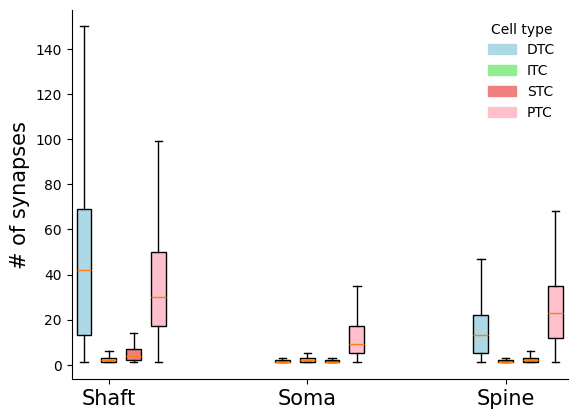

In [58]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Sample Data
np.random.seed(42)
data = [
    [
        IE_cell.query('cell_type_pre == "DTC" and target_structure == "shaft"')['total_synapses'], 
        IE_cell.query('cell_type_pre == "ITC" and target_structure == "shaft"')['total_synapses'], 
        IE_cell.query('cell_type_pre == "STC" and target_structure == "shaft"')['total_synapses'],
        IE_cell.query('cell_type_pre == "PTC" and target_structure == "shaft"')['total_synapses']
    ],
    [
        IE_cell.query('cell_type_pre == "DTC" and target_structure == "soma"')['total_synapses'], 
        IE_cell.query('cell_type_pre == "ITC" and target_structure == "soma"')['total_synapses'], 
        IE_cell.query('cell_type_pre == "STC" and target_structure == "soma"')['total_synapses'],
        IE_cell.query('cell_type_pre == "PTC" and target_structure == "soma"')['total_synapses']
    ],
    [
        IE_cell.query('cell_type_pre == "DTC" and target_structure == "spine"')['total_synapses'], 
        IE_cell.query('cell_type_pre == "ITC" and target_structure == "spine"')['total_synapses'], 
        IE_cell.query('cell_type_pre == "STC" and target_structure == "spine"')['total_synapses'],
        IE_cell.query('cell_type_pre == "PTC" and target_structure == "spine"')['total_synapses']
    ],
    #[
    #    IE_cell.query('cell_type_pre == "DTC" and target_structure == "unknown"')['total_synapses'], 
    #    IE_cell.query('cell_type_pre == "ITC" and target_structure == "unknown"')['total_synapses'], 
    #    IE_cell.query('cell_type_pre == "STC" and target_structure == "unknown"')['total_synapses'],
    #    IE_cell.query('cell_type_pre == "PTC" and target_structure == "unknown"')['total_synapses']
    #]
]

# Settings
colors = ["lightblue", "lightgreen", "lightcoral", "pink"]
positions = np.arange(len(data)) * 8  # space between groups

fig, ax = plt.subplots()

# Plot each group
for i, group in enumerate(data):
    for j, vals in enumerate(group):
        ax.boxplot(vals, positions=[positions[i] + j],
                   patch_artist=True, showfliers=False,
                   widths=0.6,
                   boxprops=dict(facecolor=colors[j]))

# X-axis labels
ax.set_xticks(positions + 1, ["Shaft", "Soma", "Spine"], fontsize=15)#, "Unknown"])
ax.set_ylabel("# of synapses", fontsize=15)

labels = ["DTC", "ITC", "STC", "PTC"]
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(colors))]
ax.legend(handles=patches, title="Cell type", frameon=False)

# Remove top & right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()


In [59]:
cell_ssi = pd.read_feather('cell_ssi.feather')

In [65]:
IE_cell["post_pt_root_id"]

0       864691132534275418
1       864691132534275418
2       864691132534275418
3       864691132534275418
4       864691132534275418
               ...        
5023    864691133313665616
5024    864691133313665616
5025    864691133313665616
5026    864691133313665616
5027    864691133313665616
Name: post_pt_root_id, Length: 5028, dtype: int64

In [66]:
IE_cell_ssi = IE_cell[IE_cell["post_pt_root_id"].isin(cell_ssi['pt_root_id'])]

In [67]:
IE_cell_ssi

,post_pt_root_id,ei_pre,ei_post,cell_type_pre,cell_type_post,target_structure,num_connections,total_synapses,sum_size,syn_ratio,avg_eucl_dist
139,864691132574630714,I,E,DTC,L3-IT,shaft,36,68,40296,592.588235,518.547493
140,864691132574630714,I,E,DTC,L3-IT,spine,9,13,7331,563.923077,550.577968
141,864691132574630714,I,E,ITC,L3-IT,soma,1,1,1245,1245.000000,837.312946
142,864691132574630714,I,E,PTC,L3-IT,shaft,13,17,18017,1059.823529,606.075656
143,864691132574630714,I,E,PTC,L3-IT,soma,5,7,6764,966.285714,561.755978
...,...,...,...,...,...,...,...,...,...,...,...
4982,864691133071419081,I,E,PTC,L3-IT,shaft,20,41,43497,1060.902439,557.725784
4983,864691133071419081,I,E,PTC,L3-IT,soma,4,7,7972,1138.857143,560.846502
4984,864691133071419081,I,E,PTC,L3-IT,spine,20,28,20583,735.107143,504.766375
4985,864691133071419081,I,E,STC,L3-IT,shaft,6,6,2170,361.666667,503.846331


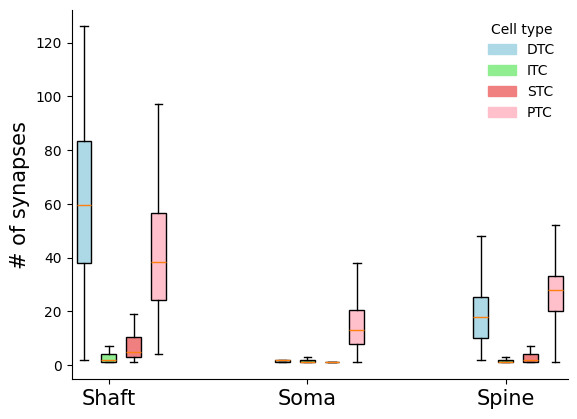

In [68]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Sample Data
np.random.seed(42)
data = [
    [
        IE_cell_ssi.query('cell_type_pre == "DTC" and target_structure == "shaft"')['total_synapses'], 
        IE_cell_ssi.query('cell_type_pre == "ITC" and target_structure == "shaft"')['total_synapses'], 
        IE_cell_ssi.query('cell_type_pre == "STC" and target_structure == "shaft"')['total_synapses'],
        IE_cell_ssi.query('cell_type_pre == "PTC" and target_structure == "shaft"')['total_synapses']
    ],
    [
        IE_cell_ssi.query('cell_type_pre == "DTC" and target_structure == "soma"')['total_synapses'], 
        IE_cell_ssi.query('cell_type_pre == "ITC" and target_structure == "soma"')['total_synapses'], 
        IE_cell_ssi.query('cell_type_pre == "STC" and target_structure == "soma"')['total_synapses'],
        IE_cell_ssi.query('cell_type_pre == "PTC" and target_structure == "soma"')['total_synapses']
    ],
    [
        IE_cell_ssi.query('cell_type_pre == "DTC" and target_structure == "spine"')['total_synapses'], 
        IE_cell_ssi.query('cell_type_pre == "ITC" and target_structure == "spine"')['total_synapses'], 
        IE_cell_ssi.query('cell_type_pre == "STC" and target_structure == "spine"')['total_synapses'],
        IE_cell_ssi.query('cell_type_pre == "PTC" and target_structure == "spine"')['total_synapses']
    ],
    #[
    #    IE_cell.query('cell_type_pre == "DTC" and target_structure == "unknown"')['total_synapses'], 
    #    IE_cell.query('cell_type_pre == "ITC" and target_structure == "unknown"')['total_synapses'], 
    #    IE_cell.query('cell_type_pre == "STC" and target_structure == "unknown"')['total_synapses'],
    #    IE_cell.query('cell_type_pre == "PTC" and target_structure == "unknown"')['total_synapses']
    #]
]

# Settings
colors = ["lightblue", "lightgreen", "lightcoral", "pink"]
positions = np.arange(len(data)) * 8  # space between groups

fig, ax = plt.subplots()

# Plot each group
for i, group in enumerate(data):
    for j, vals in enumerate(group):
        ax.boxplot(vals, positions=[positions[i] + j],
                   patch_artist=True, showfliers=False,
                   widths=0.6,
                   boxprops=dict(facecolor=colors[j]))

# X-axis labels
ax.set_xticks(positions + 1, ["Shaft", "Soma", "Spine"], fontsize=15)#, "Unknown"])
ax.set_ylabel("# of synapses", fontsize=15)

labels = ["DTC", "ITC", "STC", "PTC"]
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(colors))]
ax.legend(handles=patches, title="Cell type", frameon=False)

# Remove top & right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()
